# Tesla Stock Analysis

### Getting Data

In [437]:
import pandas as pd

tesla = pd.read_csv("tesla_dataset.csv")
tesla["Date"] = pd.to_datetime(tesla["Date"])

# Adjust the date
tesla = tesla[(tesla["Date"] >= "2021-05-30") & (tesla["Date"] <= "2022-05-31")]

print(tesla)

           Date        Open        High         Low       Close   Adj Close  \
2749 2021-06-01  209.266663  211.266663  206.850006  207.966660  207.966660   
2750 2021-06-02  206.710007  207.786667  199.713333  201.706665  201.706665   
2751 2021-06-03  200.600006  201.516663  190.406662  190.946671  190.946671   
2752 2021-06-04  193.236664  200.203339  192.399994  199.683334  199.683334   
2753 2021-06-07  197.276672  203.333328  194.293335  201.710007  201.710007   
...         ...         ...         ...         ...         ...         ...   
2997 2022-05-24  217.843338  217.973328  206.856674  209.386673  209.386673   
2998 2022-05-25  207.949997  223.106674  207.669998  219.600006  219.600006   
2999 2022-05-26  220.473328  239.556671  217.886673  235.910004  235.910004   
3000 2022-05-27  241.083328  253.266663  240.176666  253.210007  253.210007   
3001 2022-05-31  257.946655  259.600006  244.743332  252.753326  252.753326   

         Volume  
2749   54254700  
2750   69908400

In [439]:
import matplotlib.pyplot as plt
import pandas as pd

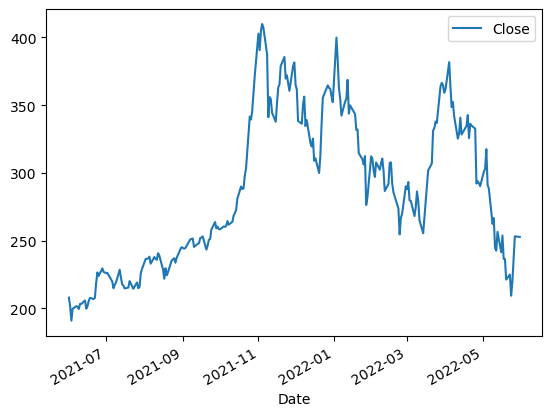

In [441]:
tesla['Date'] = pd.to_datetime(tesla['Date'])

tesla.plot(x='Date', y='Close')

plt.show()

### Simple buy at open and sell at close trading strategy

In [444]:
# dates in datetime
tesla["Date"] = pd.to_datetime(tesla["Date"])
tesla = tesla.sort_values('Date')

# Calculate daily price range (Profit/Loss)
tesla["PnL"] = tesla["Close"] - tesla["Open"]
tesla['Cumulative_PnL'] = tesla['PnL'].cumsum()

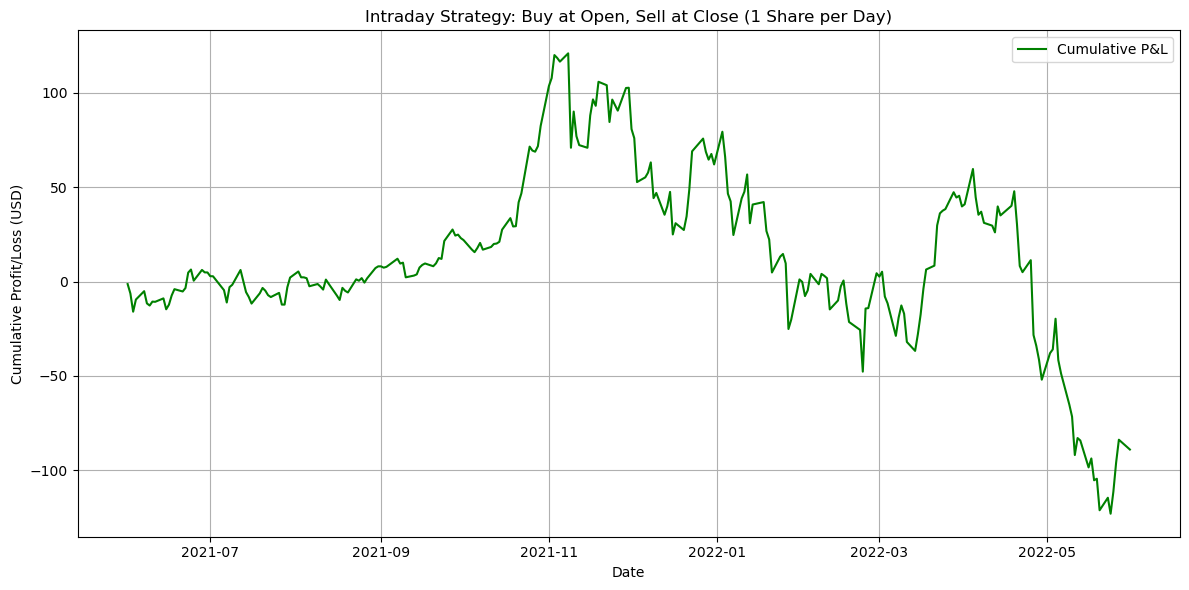

In [446]:
plt.figure(figsize=(12, 6))
plt.plot(tesla['Date'], tesla['Cumulative_PnL'], label='Cumulative P&L', color='green')
plt.title('Intraday Strategy: Buy at Open, Sell at Close (1 Share per Day)')
plt.xlabel('Date')
plt.ylabel('Cumulative Profit/Loss (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [448]:
print(f"Total Profit/Loss: ${tesla['PnL'].sum():.2f}")
print(f"Average Daily PnL: ${tesla['PnL'].mean():.2f}")
print(f"Winning Days: {(tesla['PnL'] > 0).sum()}")
print(f"Losing Days: {(tesla['PnL'] < 0).sum()}")
print(f"Max Daily Gain: ${tesla['PnL'].max():.2f}")
print(f"Max Daily Loss: ${tesla['PnL'].min():.2f}")

Total Profit/Loss: $-89.00
Average Daily PnL: $-0.35
Winning Days: 129
Losing Days: 124
Max Daily Gain: $33.46
Max Daily Loss: $-50.03


### Buy or sell when certain price deviation happens close at the end of the day. 

In [451]:
# Dates in datetime
tesla['Date'] = pd.to_datetime(tesla['Date'])
tesla = tesla.sort_values('Date')

# intrday return
tesla['ReturnPct'] = (tesla['Close'] - tesla['Open']) / tesla['Open'] * 100
threshold = 0.9 #percent
tesla["Position"] = 'None'
tesla['PnL'] = 0.0

for i, row in tesla.iterrows():
    if row['ReturnPct'] >= threshold:
        tesla.at[i, "Position"] = "Long"
        tesla.at[i, "PnL"] = row['Open'] - row['Close']
    elif row['ReturnPct'] <= -threshold:
        tesla.at[i, "Position"] = "Short"
        tesla.at[i, "PnL"] = row['Open'] - row['Close']

# Calculate cumulative profit
tesla['Cumulative_PnL'] = tesla['PnL'].cumsum()
        

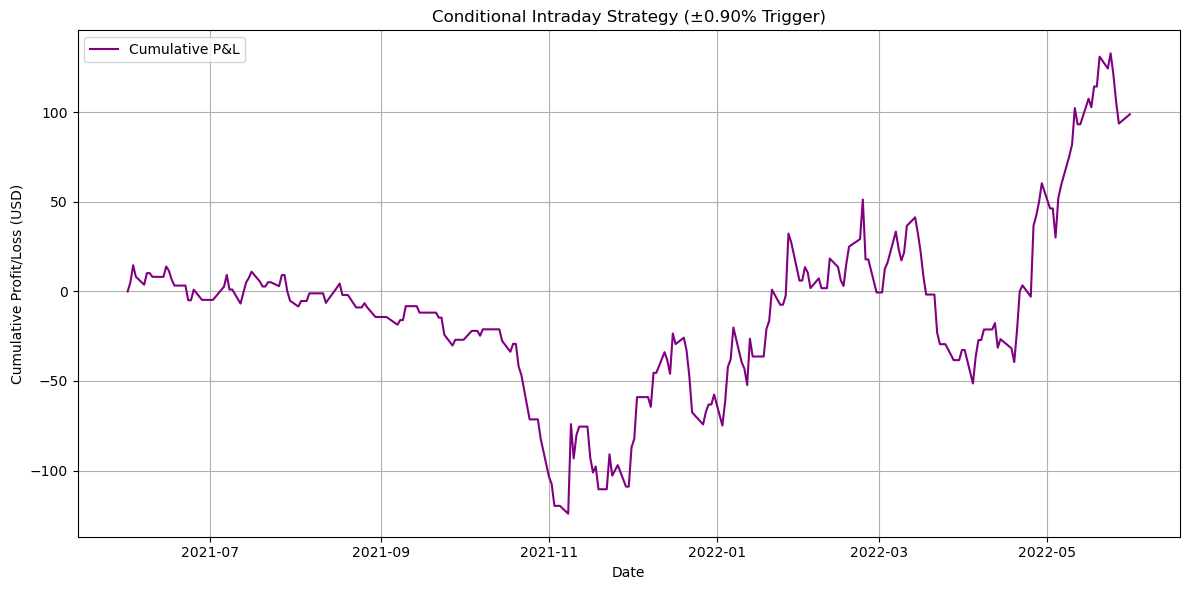

In [453]:
plt.figure(figsize=(12, 6))
plt.plot(tesla['Date'], tesla['Cumulative_PnL'], label='Cumulative P&L', color='purple')
plt.title('Conditional Intraday Strategy (±0.90% Trigger)')
plt.xlabel('Date')
plt.ylabel('Cumulative Profit/Loss (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [455]:
print(f"Total Profit/Loss: ${tesla['PnL'].sum():.2f}")
print(f"Average Trade PnL: ${tesla.loc[tesla['Position'] != 'None', 'PnL'].mean():.2f}")
print(f"Number of Trades: {(tesla['Position'] != 'None').sum()}")
print(f"Winning Trades: {(tesla['PnL'] > 0).sum()}")
print(f"Losing Trades: {(tesla['PnL'] < 0).sum()}")

Total Profit/Loss: $98.96
Average Trade PnL: $0.56
Number of Trades: 176
Winning Trades: 87
Losing Trades: 89


### Adjusted conditional strategy with buy fix and stop loss

In [458]:
threshold = 0.5  # percent threshold to trigger trade
stop_loss_pct = 1.0  # optional stop loss (in percent)

# Clear old columns
tesla["Position"] = "None"
tesla["PnL"] = 0.0

# Intraday high/low returns from open (used for stop loss)
tesla["HighReturn"] = (tesla["High"] - tesla["Open"]) / tesla["Open"] * 100
tesla["LowReturn"] = (tesla["Low"] - tesla["Open"]) / tesla["Open"] * 100

# Loop through each row to simulate trades
for i, row in tesla.iterrows():
    ret = row["ReturnPct"]

    # ---- Long trade logic ----
    if ret >= threshold:
        tesla.at[i, "Position"] = "Long"

        # Check if stop loss is hit
        if row["LowReturn"] <= -stop_loss_pct:
            # Stop loss hit → exit at stop-loss price
            stop_price = row["Open"] * (1 - stop_loss_pct / 100)
            tesla.at[i, "PnL"] = stop_price - row["Open"]
        else:
            # Normal exit at close
            tesla.at[i, "PnL"] = row["Close"] - row["Open"]

    # ---- Short trade logic ----
    elif ret <= -threshold:
        tesla.at[i, "Position"] = "Short"

        if row["HighReturn"] >= stop_loss_pct:
            # Stop loss hit → exit at stop-loss price
            stop_price = row["Open"] * (1 + stop_loss_pct / 100)
            tesla.at[i, "PnL"] = row["Open"] - stop_price
        else:
            # Normal exit at close
            tesla.at[i, "PnL"] = row["Open"] - row["Close"]

tesla['ReturnPctTrade'] = tesla['PnL'] / tesla['Open'] * 100

# Cumulative PnL
tesla["Cumulative_PnL"] = tesla["PnL"].cumsum()


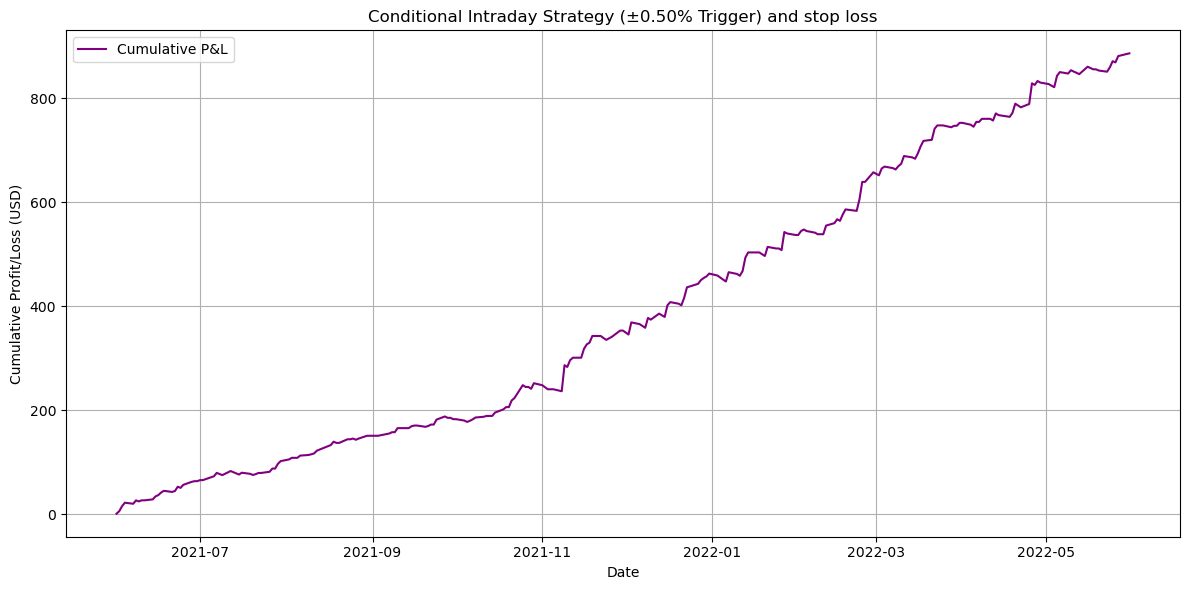

In [460]:
plt.figure(figsize=(12, 6))
plt.plot(tesla['Date'], tesla['Cumulative_PnL'], label='Cumulative P&L', color='purple')
plt.title('Conditional Intraday Strategy (±0.50% Trigger) and stop loss')
plt.xlabel('Date')
plt.ylabel('Cumulative Profit/Loss (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [462]:
trades = tesla[tesla['Position'] != 'None']

In [464]:
print(f"Total Profit/Loss: ${tesla['PnL'].sum():.2f}")
print(f"Average Trade PnL: ${tesla.loc[tesla['Position'] != 'None', 'PnL'].mean():.2f}")
print(f"Average Percent Return per Trade: {trades['ReturnPctTrade'].mean():.4f}%")
print(f"Max Return: {trades['ReturnPctTrade'].max():.2f}%")
print(f"Min Return: {trades['ReturnPctTrade'].min():.2f}%")
print(f"Number of Trades: {(tesla['Position'] != 'None').sum()}")
print(f"Winning Trades: {(tesla['PnL'] > 0).sum()}")
print(f"Losing Trades: {(tesla['PnL'] < 0).sum()}")

Total Profit/Loss: $885.82
Average Trade PnL: $4.20
Average Percent Return per Trade: 1.4585%
Max Return: 14.33%
Min Return: -1.00%
Number of Trades: 211
Winning Trades: 129
Losing Trades: 82


### Strategies performance vs buy and hold

In [467]:
total_profit = tesla['PnL'].sum()

In [469]:
total_cost = tesla.loc[tesla['Position'] != 'None', 'Open'].sum()
total_return_pct = (total_profit / total_cost) * 100

In [471]:
first_price = tesla.iloc[0]['Open']
last_price = tesla.iloc[-1]['Close']

buy_and_hold_profit = last_price - first_price
buy_and_hold_return_pct = (buy_and_hold_profit / first_price) * 100

In [473]:
# Strategy return
trades = tesla[tesla['Position'] != 'None']
total_profit = trades['PnL'].sum()
total_cost = trades['Open'].sum()
total_return_pct = (total_profit / total_cost) * 100

# Buy-and-hold return
first_price = tesla.iloc[0]['Open']
last_price = tesla.iloc[-1]['Close']
buy_and_hold_profit = last_price - first_price
buy_and_hold_return_pct = (buy_and_hold_profit / first_price) * 100

# Print summary
print(f"Total Profit from Strategy: ${total_profit:.2f}")
print(f"Total Capital Deployed: ${total_cost:.2f}")
print(f"Total Return (Strategy): {total_return_pct:.2f}%")

print(f"\nBuy and Hold Profit (1 share): ${buy_and_hold_profit:.2f}")
print(f"Buy and Hold Return: {buy_and_hold_return_pct:.2f}%")

Total Profit from Strategy: $885.82
Total Capital Deployed: $60501.51
Total Return (Strategy): 1.46%

Buy and Hold Profit (1 share): $43.49
Buy and Hold Return: 20.78%


In [475]:
# Starting capital
initial_capital = 1000

# Buy 1 share on first day, track its value over time
tesla['BuyHold_Value'] = tesla['Close'] / tesla.iloc[0]['Close'] * initial_capital

# Conditional strategy capital (starting from same base)
tesla['Strategy_Value'] = initial_capital + tesla['Cumulative_PnL']


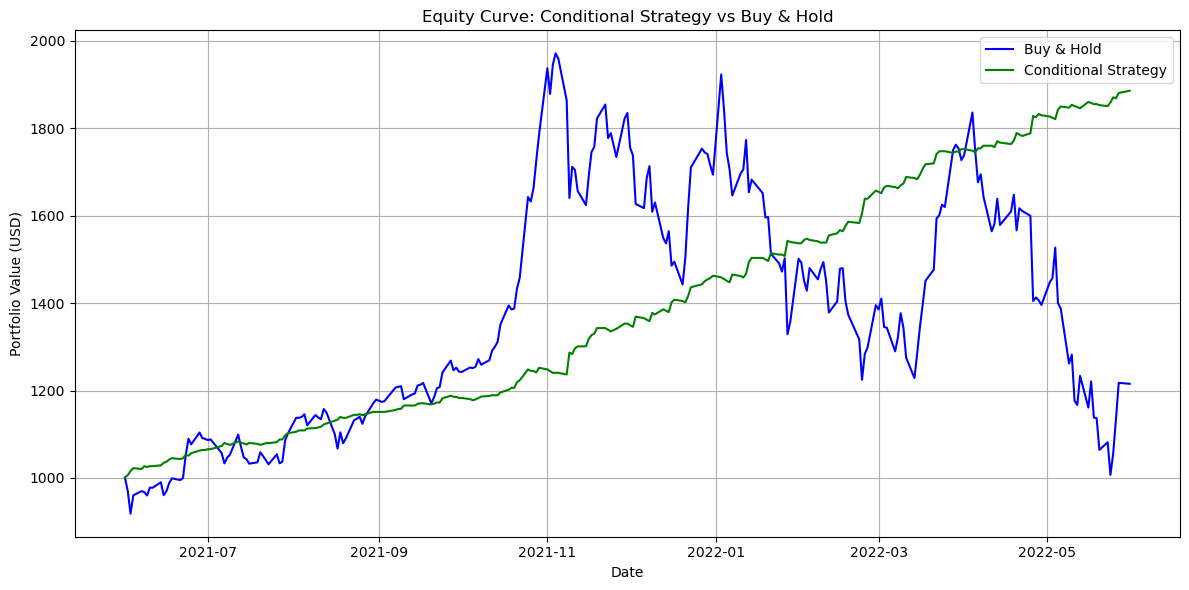

In [477]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(tesla['Date'], tesla['BuyHold_Value'], label='Buy & Hold', color='blue')
plt.plot(tesla['Date'], tesla['Strategy_Value'], label='Conditional Strategy', color='green')
plt.title('Equity Curve: Conditional Strategy vs Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


### Adding take profit logic

In [480]:
# Parameters
threshold = 0.6  # % move from open to trigger trade
stop_loss_pct = 2.0   # % from open
take_profit_pct = 8.0 # % from open

# Clear previous results
tesla["Position"] = "None"
tesla["PnL"] = 0.0

# Calculate high/low return from open (intraday)
tesla["HighReturn"] = (tesla["High"] - tesla["Open"]) / tesla["Open"] * 100
tesla["LowReturn"] = (tesla["Low"] - tesla["Open"]) / tesla["Open"] * 100

# Main loop
for i, row in tesla.iterrows():
    ret = (row["Close"] - row["Open"]) / row["Open"] * 100  # daily move

    # Long entry condition
    if ret >= threshold:
        tesla.at[i, "Position"] = "Long"
        if row["LowReturn"] <= -stop_loss_pct:
            # Hit SL
            stop_price = row["Open"] * (1 - stop_loss_pct / 100)
            tesla.at[i, "PnL"] = stop_price - row["Open"]
        elif row["HighReturn"] >= take_profit_pct:
            # Hit TP
            tp_price = row["Open"] * (1 + take_profit_pct / 100)
            tesla.at[i, "PnL"] = tp_price - row["Open"]
        else:
            # Exit at close
            tesla.at[i, "PnL"] = row["Close"] - row["Open"]

    # Short entry condition
    elif ret <= -threshold:
        tesla.at[i, "Position"] = "Short"
        if row["HighReturn"] >= stop_loss_pct:
            stop_price = row["Open"] * (1 + stop_loss_pct / 100)
            tesla.at[i, "PnL"] = row["Open"] - stop_price
        elif row["LowReturn"] <= -take_profit_pct:
            tp_price = row["Open"] * (1 - take_profit_pct / 100)
            tesla.at[i, "PnL"] = row["Open"] - tp_price
        else:
            tesla.at[i, "PnL"] = row["Open"] - row["Close"]


In [482]:
tesla['Cumulative_PnL'] = tesla['PnL'].cumsum()
tesla['ReturnPctTrade'] = tesla['PnL'] / tesla['Open'] * 100
trades = tesla[tesla['Position'] != 'None']

# Metrics
print(f"Total Profit: ${trades['PnL'].sum():.2f}")
print(f"Average % Return per Trade: {trades['ReturnPctTrade'].mean():.2f}%")
print(f"Winning Trades: {(trades['PnL'] > 0).sum()}")
print(f"Losing Trades: {(trades['PnL'] < 0).sum()}")


Total Profit: $1349.14
Average % Return per Trade: 2.33%
Winning Trades: 170
Losing Trades: 28


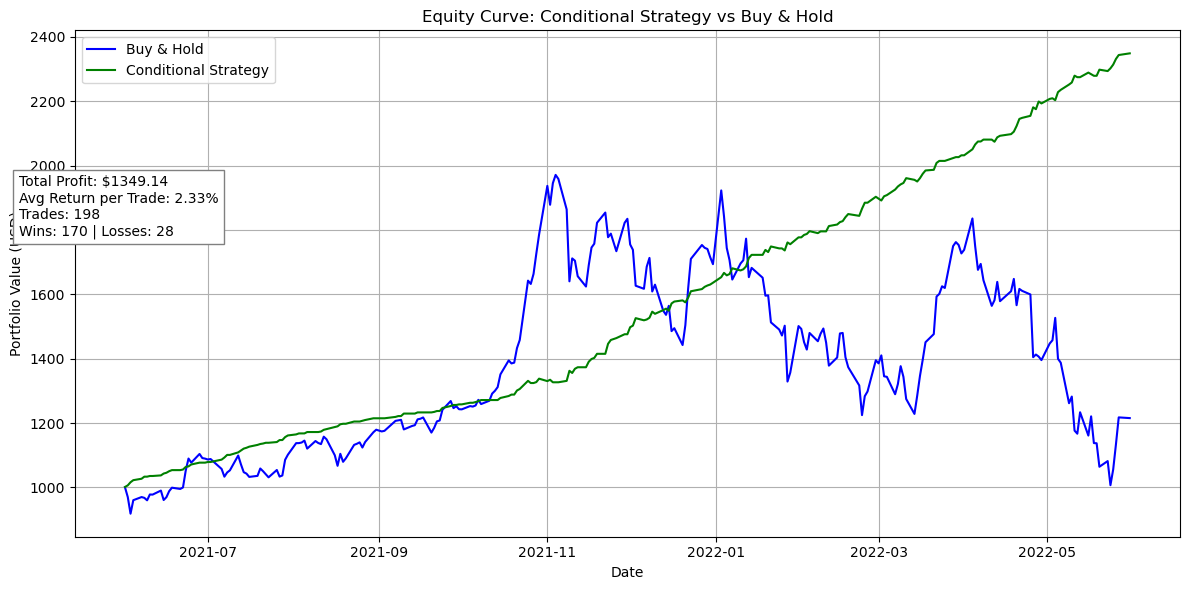

In [484]:
# Recalculate strategy value (optional, in case it's not already done)
initial_capital = 1000
tesla['BuyHold_Value'] = tesla['Close'] / tesla.iloc[0]['Close'] * initial_capital
tesla['Strategy_Value'] = initial_capital + tesla['Cumulative_PnL']

# Strategy metrics
total_profit = trades['PnL'].sum()
avg_return_pct = trades['ReturnPctTrade'].mean()
num_wins = (trades['PnL'] > 0).sum()
num_losses = (trades['PnL'] < 0).sum()
num_trades = len(trades)

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(tesla['Date'], tesla['BuyHold_Value'], label='Buy & Hold', color='blue')
plt.plot(tesla['Date'], tesla['Strategy_Value'], label='Conditional Strategy', color='green')

# Title and axis labels
plt.title('Equity Curve: Conditional Strategy vs Buy & Hold')
plt.xlabel('Date')
plt.ylabel('Portfolio Value (USD)')
plt.grid(True)
plt.legend()

# Add a textbox with strategy metrics
metrics_text = (
    f"Total Profit: ${total_profit:.2f}\n"
    f"Avg Return per Trade: {avg_return_pct:.2f}%\n"
    f"Trades: {num_trades}\n"
    f"Wins: {num_wins} | Losses: {num_losses}"
)

# Position the text box on the plot
plt.gcf().text(0.02, 0.6, metrics_text, fontsize=10, bbox=dict(facecolor='white', edgecolor='gray'))

plt.tight_layout()
plt.show()